In [2]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from matplotlib import cm

In [5]:
class Net(nn.Module):
    # n_layer: the number of hidden layers
    # n_hidden: the number of vertices in each layer
    def __init__(self, n_layer, n_hidden, dim):
        super(Net, self).__init__()
        self.dim = dim
        self.input_layer = nn.Linear(dim, n_hidden)
        self.hidden_layers = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for i in range(n_layer)])
        self.output_layer = nn.Linear(n_hidden, 1)
        
    def forward(self, x):
        o = self.act(self.input_layer(x))

        for i, li in enumerate(self.hidden_layers):
            o = self.act(li(o))
        
        out = self.output_layer(o)
        
        return out

    def act(self, x):
        return x * torch.sigmoid(x)
        # return torch.sigmoid(x)
         #return torch.tanh(x)
        # return torch.relu(x)

In [6]:
class Heat1D():
    def __init__(self, net, te, xe):
        self.net = net
        self.te = te
        self.xe = xe
    
    def __equation(self, size):
        x = torch.cat((torch.rand([size, 1]) * self.te, torch.rand([size, 1]) * self.xe), dim=1)
        x = Variable(x, requires_grad = True)

        d = torch.autograd.grad(self.net(x), x, grad_outputs = torch.ones_like(self.net(x)), create_graph=True)
        dt = d[0][:, 0].reshape(-1, 1)  # transform the vector into a column vector
        dx = d[0][:, 1].reshape(-1, 1)

        dxx = torch.autograd.grad(dx, x, grad_outputs=torch.ones_like(dx), create_graph=True)[0][:, 1].reshape(-1, 1)

        f = torch.cos(x[:,0]) * torch.cos(np.pi * x[:,1]) + np.pi**2 * torch.sin(x[:,0]) * torch.cos(np.pi * x[:,1]) 
        diff_error = (dt - dxx - f.reshape(-1, 1))**2

        return diff_error

    def __boundary(self, size):
        x = torch.cat((torch.rand([size, 1]) * self.te, torch.rand([size, 1]) * self.xe), dim=1)
        x = Variable(x, requires_grad = True)
        
        x_boundary_left = torch.cat((torch.rand([size, 1]) * self.te, torch.zeros([size, 1])), dim=1)
        x_boundary_right = torch.cat((torch.rand([size, 1]) * self.te, torch.ones([size, 1]) * self.xe), dim=1)

        bd_left_error = (self.net(x_boundary_left) - torch.sin(x[:,0]))**2
        bd_right_error = (self.net(x_boundary_right) + torch.sin(x[:,0]))**2

        return bd_left_error + bd_right_error 

    def __init(self, size):
        x_initial = torch.cat((torch.zeros(size, 1), torch.rand([size, 1]) * self.xe), dim=1)
        init_error = (self.net(x_initial)) ** 2
        return init_error

    def loss_func(self, size=2**8):
        diff_error = self.__equation(size)
        init_error = self.__init(size)
        bd_error = self.__boundary(size)
        return torch.mean(diff_error + init_error + bd_error)


class Heat2D():
    def __init__(self, net, te, xe, ye):
        self.net = net
        self.te = te
        self.xe = xe
        self.ye = ye
    
    def __equation(self, size):
        x = torch.cat((torch.rand([size, 1]) * self.te, torch.rand([size, 1]) * self.xe, torch.rand([size, 1]) * self.ye), dim=1)
        x = Variable(x, requires_grad = True)

        d = torch.autograd.grad(self.net(x), x, grad_outputs=torch.ones_like(self.net(x)), create_graph=True)
        dt = d[0][:, 0].reshape(-1, 1)  # transform the vector into a column vector
        dx = d[0][:, 1].reshape(-1, 1)
        dy = d[0][:, 2].reshape(-1, 1)
        # du/dxdx
        dxx = torch.autograd.grad(dx, x, grad_outputs=torch.ones_like(dx), create_graph=True)[0][:, 1].reshape(-1, 1)
        # du/dydy
        dyy = torch.autograd.grad(dy, x, grad_outputs=torch.ones_like(dy), create_graph=True)[0][:, 2].reshape(-1, 1)

        f = np.pi * (torch.cos(np.pi*x[:, 0])) * (torch.sin(np.pi*x[:, 1])) * (torch.sin(np.pi*x[:, 2]))\
             + 2 * np.pi * np.pi * (torch.sin(np.pi*x[:, 0])) * (torch.sin(np.pi*x[:, 1])) * (torch.sin(np.pi*x[:, 2]))

        diff_error = (dt - dxx - dyy - f.reshape(-1, 1))**2

        return diff_error

    def __boundary(self, size):
        x_boundary_left = torch.cat((torch.rand([size, 1]) * self.te, torch.zeros([size, 1]), torch.rand(size, 1) * self.ye), dim=1)
        x_boundary_right = torch.cat((torch.rand([size, 1]) * self.te, torch.ones([size, 1]) * self.xe, torch.rand(size, 1) * self.ye), dim=1)
        x_boundary_up = torch.cat((torch.rand([size, 1]) * self.te, torch.rand([size, 1]) * self.xe, torch.ones(size, 1) * self.ye), dim=1)
        x_boundary_down = torch.cat((torch.rand([size, 1]) * self.te, torch.rand([size, 1]) * self.xe, torch.zeros(size, 1)), dim=1)

        bd_left_error = (self.net(x_boundary_left)) ** 2
        bd_right_error = (self.net(x_boundary_right)) ** 2
        bd_up_error = (self.net(x_boundary_up)) ** 2
        bd_down_error = (self.net(x_boundary_down)) ** 2

        return bd_left_error + bd_right_error + bd_up_error + bd_down_error

    def __init(self, size):
        x_initial = torch.cat((torch.zeros(size, 1), torch.rand([size, 1]) * self.xe, torch.rand([size, 1]) * self.ye), dim=1)
        init_error = (self.net(x_initial)) ** 2
        return init_error

    def loss_func(self, size=2**8):
        diff_error = self.__equation(size)
        init_error = self.__init(size)
        bd_error = self.__boundary(size)

        return torch.mean(diff_error + init_error + bd_error)

In [10]:
class Train():
    def __init__(self, net, heateq, BATCH_SIZE):
        self.errors = []
        self.BATCH_SIZE = BATCH_SIZE
        self.net = net
        self.model = heateq

    def train(self, epoch, lr):
        optimizer = optim.Adam(self.net.parameters(), lr)
        avg_loss = 0
        for e in range(epoch):
            optimizer.zero_grad()
            loss = self.model.loss_func(self.BATCH_SIZE)
            avg_loss = avg_loss + float(loss.item())
            loss.backward()
            optimizer.step()
            if e % 100 == 99:
                loss = avg_loss/100
                print("Epoch {} - lr {} -  loss: {}".format(e, lr, loss))
                avg_loss = 0

                error = self.model.loss_func(2**8)
                self.errors.append(error.detach())

    def get_errors(self):
        return self.errors

    def save_model(self):
        torch.save(self.net, 'net_model.pkl')
    
    def plot_kpi(self):
        fig = plt.figure()
        plt.plot(np.log(self.errors), '-b', label='Errors')
        plt.title('Training Loss', fontsize=10)
        plt.show()

In [11]:
def solution_f(t, x):
    return -(np.pi)**2 * np.cos(np.pi*x) * np.sin(t)

class Demo():
    def __init__(self, net, heatequation, nt, nx):
        self.net = net
        self.heatequation = heatequation
        self.nt, self.nx = nt, nx
        self.t_range, self.x_range = np.linspace(0, heatequation.te, nt), np.linspace(0, heatequation.xe, nx)
    
    def get_solution(self):
        data = np.empty((self.net.dim, 1))
        self.est_solution, self.solution = [], []
        for t in self.t_range:
            data[0] = t
            for x in self.x_range:
                data[1] = x
                in_data = torch.Tensor(data.reshape(1,-1))
                self.est_solution.append(self.net(in_data).detach().cpu().numpy())
                self.solution.append(solution_f(t, x))

        self.est_solution = np.reshape(self.est_solution, (self.nt, self.nx))
        self.solution = np.reshape(self.solution, (self.nt, self.nx))
    
    def evalution(self):
        pass

    def plot_mesh(self):
        t, x = np.meshgrid(self.t_range, self.x_range, indexing='ij')
        fig1 = plt.figure()
        ax1 = fig1.gca(projection = '3d')
        ax1.set_zlim([-5,5])
        ax1.plot_surface(t, x, self.est_solution, cmap=cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
        fig1.show()

        fig2 = plt.figure()
        ax2 = fig2.gca(projection = '3d')
        ax2.set_zlim([-5,5])
        ax2.plot_surface(t, x, self.est_solution - self.solution, cmap=cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
        fig2.show()


Net(
  (input_layer): Linear(in_features=2, out_features=25, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=25, out_features=25, bias=True)
    (1): Linear(in_features=25, out_features=25, bias=True)
    (2): Linear(in_features=25, out_features=25, bias=True)
  )
  (output_layer): Linear(in_features=25, out_features=1, bias=True)
)
Epoch 99 - lr 0.002 -  loss: 14.231903910636902
Epoch 199 - lr 0.002 -  loss: 1.248640214204788
Epoch 299 - lr 0.002 -  loss: 0.7807183676958084
Epoch 399 - lr 0.002 -  loss: 0.6999836021661758
Epoch 499 - lr 0.002 -  loss: 0.6421920198202133
Epoch 599 - lr 0.002 -  loss: 0.6104976689815521
Epoch 699 - lr 0.002 -  loss: 0.586122670173645
Epoch 799 - lr 0.002 -  loss: 0.5744004988670349
Epoch 899 - lr 0.002 -  loss: 0.5633482110500335
Epoch 999 - lr 0.002 -  loss: 0.5667925423383713


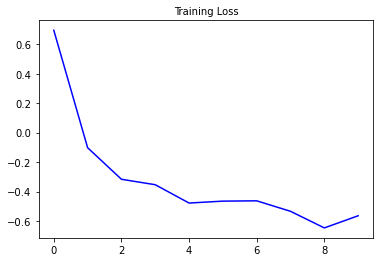

C:\Users\13393\AppData\Local\Temp\ipykernel_42672\2627693497.py:31: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax1 = fig1.gca(projection = '3d')
C:\Users\13393\AppData\Local\Temp\ipykernel_42672\2627693497.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
C:\Users\13393\AppData\Local\Temp\ipykernel_42672\2627693497.py:37: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to 

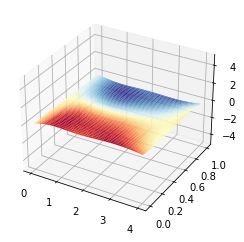

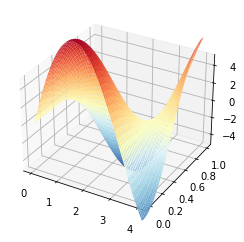

In [13]:
net = Net(n_layer = 3, n_hidden = 25, dim = 2)
print(net)

te = 4
xe = 1

heatequation = Heat1D(net, te, xe)

train = Train(net, heatequation, BATCH_SIZE = 2**10)

train.train(epoch = 10**3, lr = 0.002)

train.plot_kpi()


demo = Demo(net, heatequation, nt = 100, nx = 100)
demo.get_solution()
demo.plot_mesh()